In [1]:
import numpy as np
import os
import sys
from matplotlib import pyplot as plt
import tools21cm as t2c 
import py21cmfast as p21c
p21c.config['direc'] = '/hscratch/dante/21cmcache'
sys.path.append('/home/dante/workspace/sdc/21cmPipeline')

## Generate Coeval Boxes

In [2]:
from pipe21cm.signal.run_21cm import run_coeval_bt

In [3]:
#set redshifts
zs = np.arange(6,10.1,0.2).tolist()

# generating 21cm signal at various redshifts
# for tests we use smaller box
box_size = 128
cell_dim = 64

In [4]:

coevals= run_coeval_bt(redshift=zs, 
                        box_size=box_size, 
                        cell_dim=cell_dim, 
                        save_dir='/home/dante/workspace/sdc/sdc_data/pipline_test/128_64')


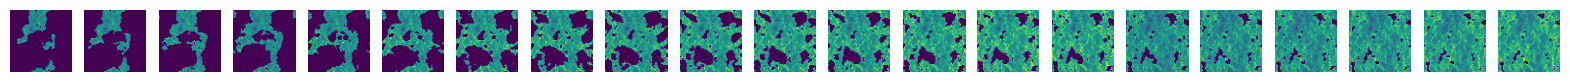

In [5]:
#plot all boxs for each redshift
plt.figure(figsize=(20, 2))
for i in range(len(zs)):
    plt.subplot(1, len(zs), i+1)
    plt.imshow(coevals[i][32])
    plt.axis('off')


## Generate Lightcone

In [6]:
from glob import glob 
from natsort import natsorted
from pipe21cm.signal.lightcone import build_physical_lightcone,build_observational_lightcone
from pipe21cm.utils import plot_lightcone

In [7]:
file_list = natsorted(glob('/home/dante/workspace/sdc/sdc_data/pipline_test/128_64/*'))

#build lightcones 
lc_physical,lc_zs = build_physical_lightcone(file_list=file_list, 
                                                redshifts=np.array(zs), 
                                                box_size=box_size)



Making lightcone between 6.000000 < z < 9.999369


100%|██████████| 630/630 [00:00<00:00, 5148.73it/s]

...done


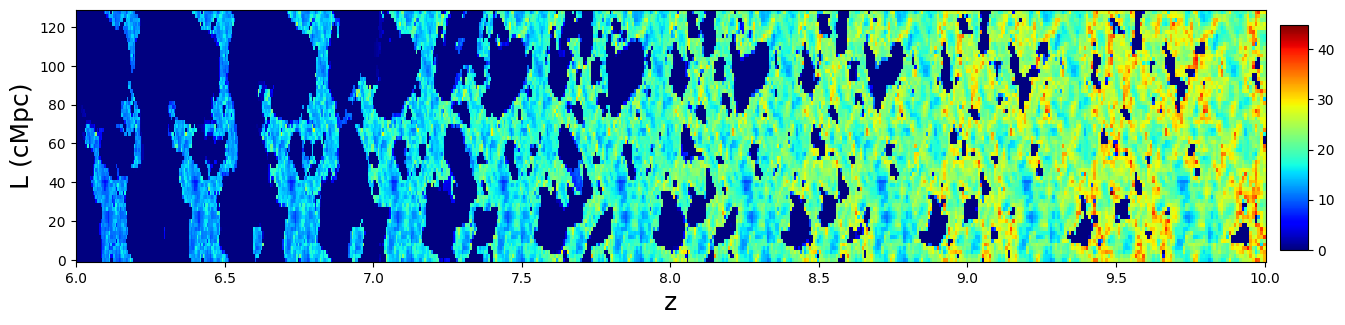

In [8]:
plot_lightcone(lc_physical, lc_zs, box_size)

## Telescope Effects

Define Telescope and observation strategy

In [9]:
from pipe21cm.telescope import Telescope

tele = Telescope(cell_dim, 
                 box_size, 
                 lc_zs, 
                 subarray_type="AA4", 
                 obs_time=1000.0, 
                 total_int_time=6.0, 
                 int_time=10.0, 
                 declination=-30.0, 
                 n_jobs=16)

generate uv maps

In [10]:
tele.build_lightcone_uv_map(save_uvmap_path='/home/dante/workspace/sdc/sdc_data/pipline_test/telescope/uvmap_AA4.pkl')

AA4 contains 512 antennae.
ENU -> ECEF -> XYZ


Apply uv maps to input signals

In [11]:
lc_physical_uv_applied = tele.apply_uv_response_on_lightcone(lc_physical)

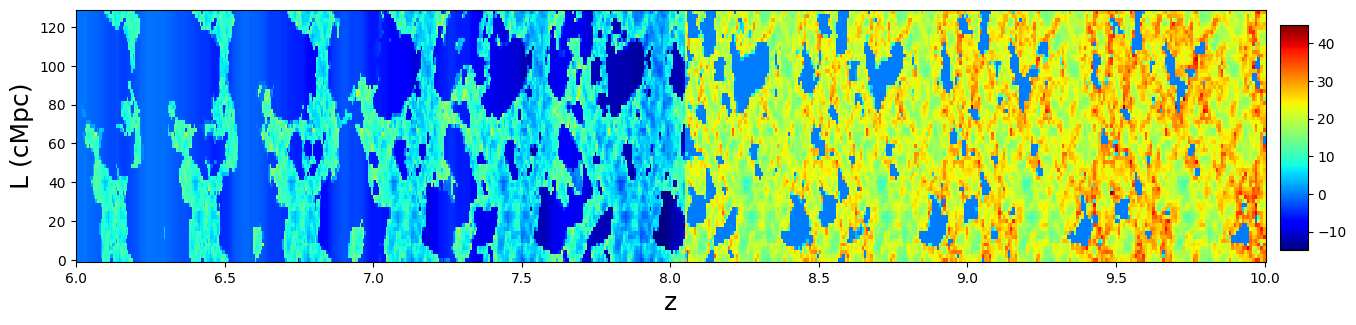

In [12]:
plot_lightcone(lc_physical_uv_applied, lc_zs, box_size)

Generate noise

In [13]:
lc_ns = tele.get_noise_lightcone()
lc_final,_ = t2c.smooth_lightcone(lc_ns+lc_physical_uv_applied, lc_zs, box_size)

AA4 contains 512 antennae.
ENU -> ECEF -> XYZ
Creating noise lightcone...


Generating noise slices:   7%|▋         | 41/630 [00:00<00:02, 203.82it/s]

100%|██████████| 630/630 [00:00<00:00, 3083.01it/s]


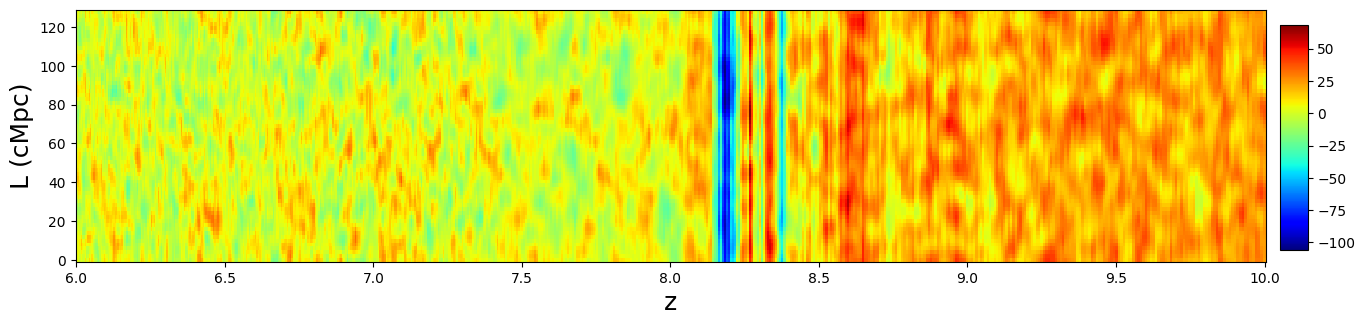

In [14]:
plot_lightcone(lc_final, lc_zs, box_size)

In [15]:
#build observational lightcones
lc_obs, lc_freqs = build_observational_lightcone(file_list=file_list, 
                                                redshifts=np.array(zs), 
                                                box_size=box_size,
                                                physical_lightcone=lc_final)

0.857700865063322


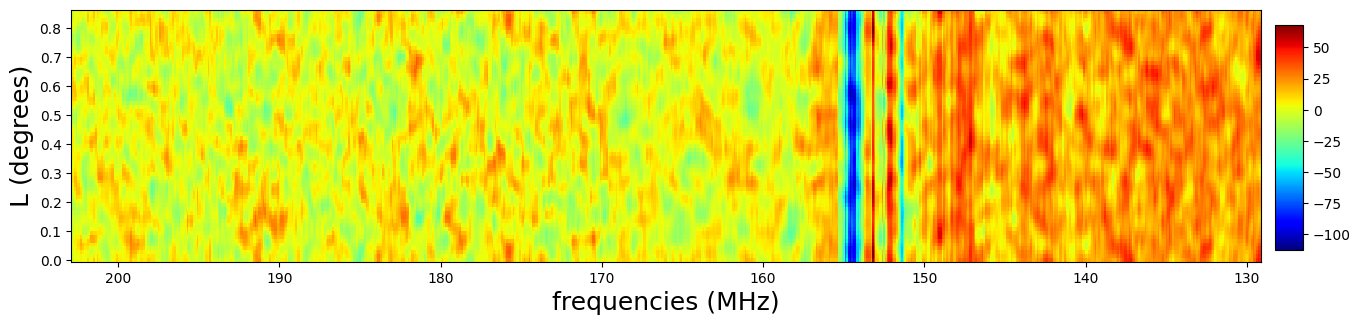

In [16]:
max_deg = np.max(t2c.angular_size_comoving(box_size, lc_zs))
print(max_deg)
plot_lightcone(lc_obs, lc_freqs, max_deg, type='observational')

## Summary Statistics

In [17]:
from pipe21cm.summary.power_spectrum import calculate_1dpk,calculate_2dpk

In [26]:
# 1dps, bs, st are calculated for each coeval box
cube = coevals[-1]

nkbins = 15
ks,pk = calculate_1dpk(cube,box_size=128,kbins=nkbins)

Text(0.5, 1.0, '1D Power Spectrum')

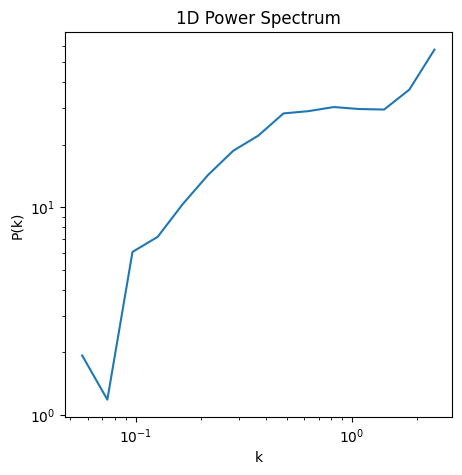

In [27]:
plt.figure(figsize=(5,5))

plt.loglog(ks,pk)
plt.xlabel('k')
plt.ylabel('P(k)')
plt.title('1D Power Spectrum')

In [28]:
# 2dps are calculated for the lightcone
kper_mid, kpar_mid, p2d = calculate_2dpk(lc_physical, box_size=128, kbins=nkbins)

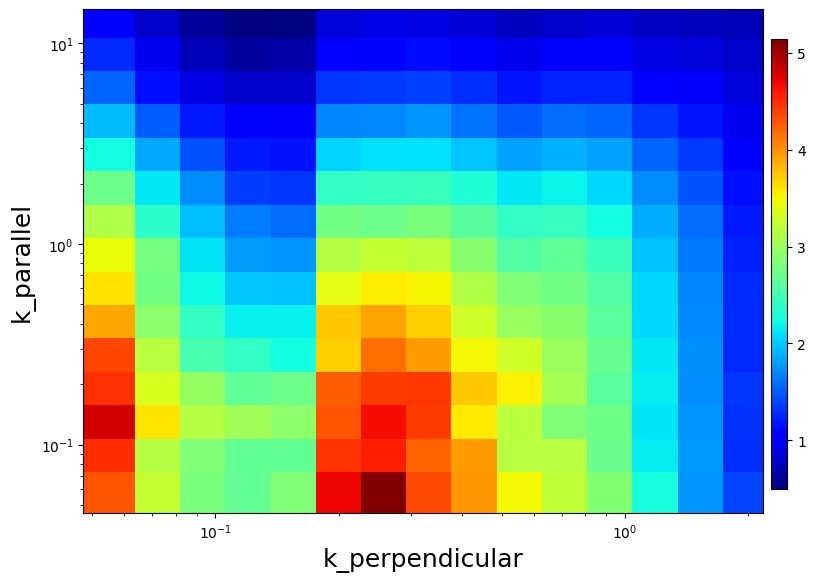

In [29]:
#plot 2D power spectrum
fig, axs = plt.subplots(1,1, figsize=(8, 6))
im = axs.pcolor(kper_mid, kpar_mid, np.log10(p2d), cmap='jet')
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlabel('k_perpendicular', fontsize=18)
axs.set_ylabel('k_parallel', fontsize=18)
#add colorbar
fig.subplots_adjust(bottom=0.11, right=0.91, top=0.95, left=0.06)
cax = plt.axes([0.92, 0.15, 0.02, 0.75])
fig.colorbar(im,cax=cax)